# Masking and reducing datacubes using geometry objects

In [1]:
import xarray as xr
import numpy as np
from earthkit.data.testing import earthkit_remote_test_data_file
from earthkit.climate import shapes
import matplotlib.pyplot as plt

from earthkit import data as ek_data


In [2]:
era5_file = "era5_temperature_europe_2015.grib"
remote_era5_file = earthkit_remote_test_data_file("test-data", era5_file)
era5_data = ek_data.from_source("url", remote_era5_file)

era5_data.to_xarray().to_netcdf('test_data/test_gridded_data.nc')

In [3]:
era5_dataset = era5_data.to_xarray()
era5_dataarray = era5_dataset.t2m  #.drop_vars(["step", "surface", "number", "valid_time"])
era5_dataarray

<xarray.DataArray 't2m' (number: 1, time: 1460, step: 1, surface: 1,
                         latitude: 201, longitude: 281)>
[82462260 values with dtype=float32]
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] ...
Attributes: (12/30)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      56481
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown

In [4]:
nuts_geojson = "NUTS_RG_60M_2021_4326_LEVL_0.geojson"
remote_nuts_url = earthkit_remote_test_data_file("test-data", nuts_geojson)
nuts_data = ek_data.from_source("url", remote_nuts_url)
nuts_geodataframe = nuts_data.to_pandas()
nuts_geodataframe[:5]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160..."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7..."


## Mask dataarray with geodataframe

In [5]:
era5_data.to_xarray(xarray_open_dataset_kwargs=dict(chunks={'time':48}, squeeze=True)).t2m # xarray_open_dataset_kwargs=dict(chunks={'time':48})

In  , overriding the default value (chunks=None) with chunks={'time': 48} is not recommended.
In  , overriding the default value (squeeze=False) with squeeze=True is not recommended.


<xarray.DataArray 't2m' (time: 1460, latitude: 201, longitude: 281)>
dask.array<open_dataset-t2m, shape=(1460, 201, 281), dtype=float32, chunksize=(48, 201, 281), chunktype=numpy.ndarray>
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Attributes: (12/30)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      56481
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown

In [7]:
masked_data = shapes.masks(era5_data, nuts_data)
masked_data.squeeze()

<xarray.DataArray 't2m' (FID: 37, time: 1460, latitude: 201, longitude: 281)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * FID         (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'
Attributes: (12/30)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      56481
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown

Text(0.5, 1.0, 'Masked Germany Zoom')

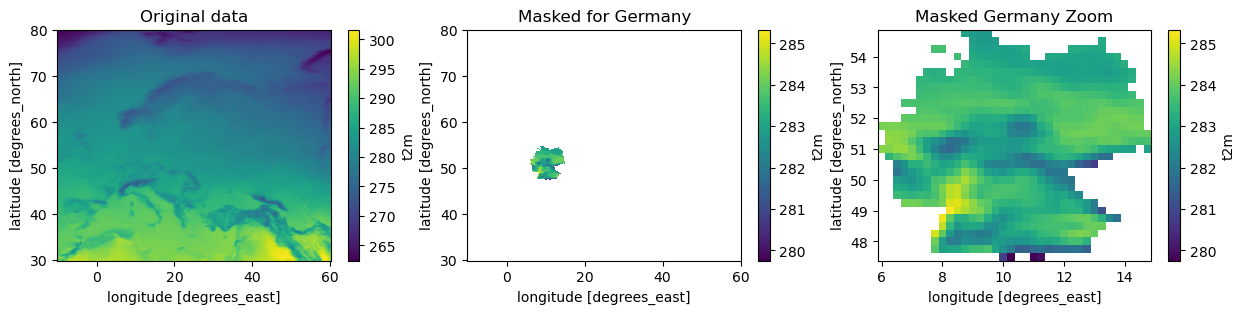

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))
era5_dataarray.mean(dim='time').plot(ax=axes[0])
axes[0].set_title('Original data')
masked_data.sel(FID='DE').mean(dim='time').plot(ax=axes[1])
axes[1].set_title('Masked for Germany')
germany_data = masked_data.sel(FID='DE').dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
germany_data.mean(dim='time').plot(ax=axes[2])
axes[2].set_title('Masked Germany Zoom')

## Reduce data
### Default behaviour inserts reduced data into geodataframe
[An] additional column[s] is[/are] added to the geodataframe which contains an xarray.DataArray of the reduced data. The column header is constructed from the variable name and the how method applied

In [9]:
reduced_data = shapes.reduce(era5_data, nuts_data)
reduced_data.iloc[:5]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,t2m_mean
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...","[278.70923, 279.765, 279.77222, 279.57568, 279..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160...","[257.4673, 256.88065, 264.83875, 263.44513, 26..."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57...","[275.7629, 275.43472, 275.91312, 276.8525, 277..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35...","[274.514, 273.25146, 275.95157, 273.73346, 272..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7...","[273.99857, 272.70166, 282.6711, 278.778, 274...."


In [10]:
reduced_data.attrs

{'t2m_attrs': {'GRIB_paramId': 167,
  'GRIB_dataType': 'an',
  'GRIB_numberOfPoints': 56481,
  'GRIB_typeOfLevel': 'surface',
  'GRIB_stepUnits': 1,
  'GRIB_stepType': 'instant',
  'GRIB_gridType': 'regular_ll',
  'GRIB_NV': 0,
  'GRIB_Nx': 281,
  'GRIB_Ny': 201,
  'GRIB_cfName': 'unknown',
  'GRIB_cfVarName': 't2m',
  'GRIB_gridDefinitionDescription': 'Latitude/Longitude Grid',
  'GRIB_iDirectionIncrementInDegrees': 0.25,
  'GRIB_iScansNegatively': 0,
  'GRIB_jDirectionIncrementInDegrees': 0.25,
  'GRIB_jPointsAreConsecutive': 0,
  'GRIB_jScansPositively': 0,
  'GRIB_latitudeOfFirstGridPointInDegrees': 80.0,
  'GRIB_latitudeOfLastGridPointInDegrees': 30.0,
  'GRIB_longitudeOfFirstGridPointInDegrees': -10.0,
  'GRIB_longitudeOfLastGridPointInDegrees': 60.0,
  'GRIB_missingValue': 9999,
  'GRIB_name': '2 metre temperature',
  'GRIB_shortName': '2t',
  'GRIB_totalNumber': 0,
  'GRIB_units': 'K',
  'long_name': '2 metre temperature',
  'units': 'K',
  'standard_name': 'unknown'},
 't2m_me

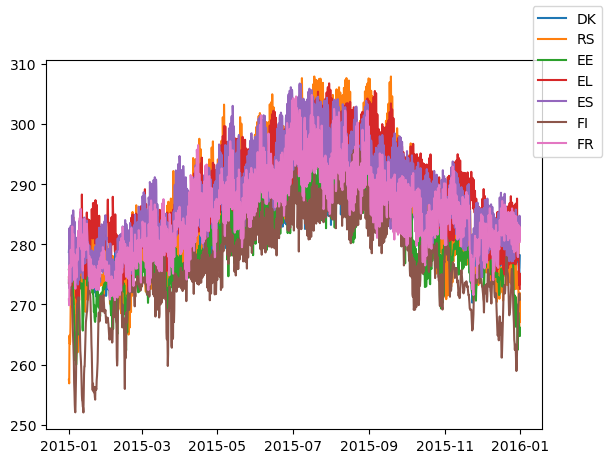

In [11]:
plot_var = "t2m_mean"
plot_x_vals = reduced_data.attrs[f"{plot_var}_dims"]["time"]
fig, ax = plt.subplots(1)
for i, feature in reduced_data.iterrows():
    ax.plot(plot_x_vals, feature['t2m_mean'].squeeze(), label=feature['FID'])
    # feature['t2m_mean'].plot(ax=ax, label=feature['FID'])
    if i>5:
        break
fig.legend()

## Can provide additional dimensions to reduce along

This is advisable with such analysis as it ensures correctly handled and weihted missing values

In [12]:
reduced_data = shapes.reduce(era5_data, nuts_data, extra_reduce_dims='time')
reduced_data.iloc[:5]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,t2m_mean
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...",282.48444
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160...",285.00317
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57...",280.56302
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35...",288.2147
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7...",287.7985


### TODO: Use earthkit polygon plotting here

## Can provide weights for reduction

Or use predefined weights options, i.e. `latitude`

## Can return the object as an xarray

TODO: how to attach to original geometry?

In [14]:
reduced_data_xr = shapes.reduce(era5_data, nuts_data, how=np.nanmax, weights='latitude', return_as='xarray')
reduced_data_xr

/Users/edwardcomyn-platt/miniconda3/envs/earthkit/lib/python3.10/site-packages/xarray/core/variable.py:2012: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)
/Users/edwardcomyn-platt/miniconda3/envs/earthkit/lib/python3.10/site-packages/xarray/core/variable.py:2012: RuntimeWarning: All-NaN slice encountered
  data = func(self.data, axis=axis, **kwargs)


<xarray.DataArray 't2m' (FID: 37, time: 1460)>
array([[279.88135, 280.61102, 281.33185, ..., 277.7212 , 280.78748,
        281.04398],
       [264.86768, 266.3454 , 269.08966, ..., 268.93408, 273.9906 ,
        269.51077],
       [277.11377, 277.34735, 277.97247, ..., 271.02783, 271.52966,
        270.31937],
       ...,
       [274.09814, 275.03876, 276.59552, ..., 269.32666, 273.7621 ,
        271.876  ],
       [280.16846, 279.87665, 278.94513, ..., 281.21338, 283.03357,
        282.04788],
       [281.73486, 282.1579 , 281.6502 , ..., 281.2251 , 280.1527 ,
        280.6592 ]], dtype=float32)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
  * FID         (FID) object 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'
Attributes: (12/30)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      56481
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown

In [15]:
reduced_data_xr.to_netcdf('test_data/test_reduced.nc')


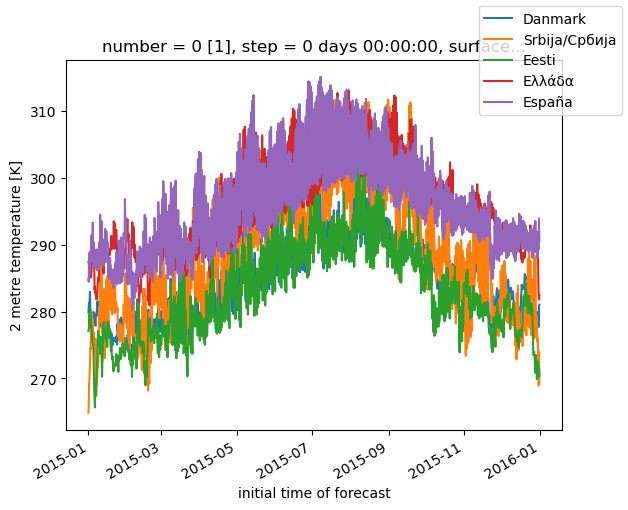

In [35]:
fig, ax = plt.subplots(1)
for i, feature in nuts_data.to_pandas().iterrows():
    reduced_data_xr.sel(FID=feature["FID"]).plot(ax=ax, label=feature["NUTS_NAME"])
    if i>3:
        break
fig.legend()
